# Tutorial - Deep Supervised Learning: Multilayer Perceptron and CNN (Tensorflow implementation)

In this tutorial lesson, we will try to classify the 
<a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> model using two different 
network achitectures:
- A multilayer poerceptron made only of linear layers
- A CNN network made of two convolutional layers and two pooling layers before feeding data through fully connected hidden layers. 
- The implementation of the CNN is left as an exercise

## Perform standard imports

In [1]:
# %matplotlib notebook  # enable this option to change the size of the figure in the notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist

from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

from sklearn.metrics import confusion_matrix  # for evaluating results


## Load the MNIST dataset
Data are already split into train and test. Below we load the data and print their shape.

- The training set consists of 60000 items. Each item is a grayscale image of size 28 * 28, corresponding to one digit from 0 to 9. The dataset contains also the true label corresponding to each image.
- The test set is organized as the training set but contains only 10000 items.
- Each X and y item is numpy array

In [2]:
# load dataset
(X_train_data, y_train_data), (X_test_data, y_test_data) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train_data.shape, y_train_data.shape))
print('Test: X=%s, y=%s' % (X_test_data.shape, y_test_data.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [3]:
print(type(X_test_data[0]))

<class 'numpy.ndarray'>


### Examine the training data

**EXERCISE**: Call the first 5 items in the training data and visualize the image and the correct label.

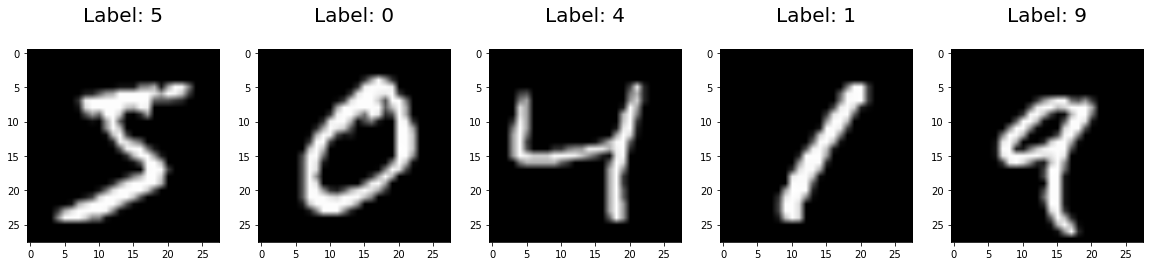

In [4]:
plt.figure(figsize=(20,4))
for index in range(5):
    image, label = X_train_data[index], y_train_data[index]
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray, interpolation='bilinear')
    plt.title('Label: %i\n' % label, fontsize = 20);

### Normalize and prepare the data
If we use *np.max* we can see that our data are not normalized (the maximum of each item coul be up to 255). 

In [5]:
np.max(X_train_data[0])

255

So we need to normalize the data as follows:

In [6]:
X_train_data, X_test_data = X_train_data / 255.0, X_test_data / 255.0 

In [7]:
np.max(X_train_data[0])

1.0

We also need to add one dimension to the data to train the model

In [8]:
X_train_data = X_train_data[..., tf.newaxis].astype("float32")
X_test_data = X_test_data[..., tf.newaxis].astype("float32")

## Batch loading 

In [9]:
tf.random.set_random_seed(10)  # for consistent results
train_ds = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data)).shuffle(10000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_data, y_test_data)).batch(500)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### How are we loading the data?

In [10]:
for b, (images,labels) in enumerate(train_ds): 
    break

print(images.shape)
print(labels.shape)
b

(100, 28, 28, 1)
(100,)


0

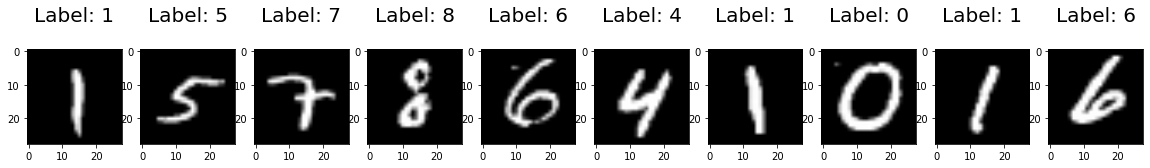

In [11]:
n_images = 10
plt.figure(figsize=(20,n_images))
for index in range(n_images):
    image, label = images[index], labels[index]
    plt.subplot(1, n_images, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray, interpolation='bilinear')
    plt.title('Label: %i\n' % label, fontsize = 20);

# MULTIPLAYER PERCEPTRON

## Define the model
- Our input size is 784 once we flatten the incoming 28x28 tensors.<br>
- Our output size represents the 10 possible digits.<br>
- We'll set our hidden layers to [120, 84] for now. Once you've completed the exercise feel free to come back and try different values.

In [12]:
class MultilayerPerceptron(Model):
    def __init__(self, in_sz=784, out_sz=10, layers_sz=[120,84]):
        super(MultilayerPerceptron,self).__init__()        
        self.input_layer = layers.InputLayer(input_shape = (in_sz,))
        self.fc1 = layers.Dense(layers_sz[0], activation = 'relu')
        self.fc2 = layers.Dense(layers_sz[1], activation = 'relu')
        self.output_layer = layers.Dense(out_sz)
    
    @tf.function
    def call(self,X):
        #X = self.input_layer(X)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.output_layer(X)
        return X  

In [13]:
model = MultilayerPerceptron()
model

## Define loss function & optimizer

In [14]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(lr=0.001)

## Train the model
We'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.

Before starting the training it is important to remind how we do the following operations:

1. **Flatten the training data**. If X_train is the original batch of shape (100, 28, 28, 1), this can be done using:  
<br>
<pre>
X_train = tf.reshape(X_train, shape = (100,-1)) </pre>
2. **Generate predictions**. This is done in the function *train_step* or *test_step*, as follows:
<br>
<pre>
predictions = model(X_train, training=True)</pre>



**QUESTION** : if the shape of my original batch images is(100, 1, 28, 28), 
what do  I obtain when I do *images = tf.reshape(images, shape = (100,-1))*?

In [15]:
import time 
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    print(i)
    trn_corr = 0
    tst_corr = 0
    
    # Run the train batches
    for b, (X_train, y_train) in enumerate(train_ds):
        b += 1
        
        # Apply the model
        X_train = tf.reshape(X_train, shape=(100,-1))  # Here we flatten the images
        with tf.GradientTape() as tape:
            y_pred = model(X_train, training=True) 
            loss = criterion(y_train, y_pred)
        
        # Tally the number of correct predictions
        predicted = tf.argmax(y_pred, 1).numpy()
        batch_corr = np.equal(y_train.numpy(), predicted).sum()
        trn_corr += batch_corr
        
        # Update the parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.numpy():10.8f}  \
accuracy: {trn_corr*100/(100*b):7.3f}%')

    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)

    
    # Run the testing batches
    for b, (X_test, y_test) in enumerate(test_ds):
        
        # Apply the model
        X_test = tf.reshape(X_test, shape=(500,-1))
        y_val = model(X_test, training=False)
        predicted = tf.argmax(y_val, 1).numpy()
        tst_corr += np.equal(y_test.numpy(),predicted).sum()
        
    loss = criterion(y_test, y_val)        
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
end_time = time.time()
print(f'\nDuration: {end_time - start_time:.0f} seconds') # print the time elapsed            

0
epoch:  0  batch:  200 [ 20000/60000]  loss: 0.24198036  accuracy:  85.570%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.15298113  accuracy:  89.377%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.14409423  accuracy:  91.168%
1
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.11833414  accuracy:  95.510%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.08978078  accuracy:  95.782%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.08198830  accuracy:  96.092%
2
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.05356354  accuracy:  97.115%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.06474873  accuracy:  97.185%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.04028650  accuracy:  97.283%
3
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.02163560  accuracy:  97.925%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.04506287  accuracy:  97.925%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.01945194  accuracy:  97.957%
4
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.01282515  accuracy:  98.420%
ep

**EXERCISE**:  Plot the loss and accuracy comparisons

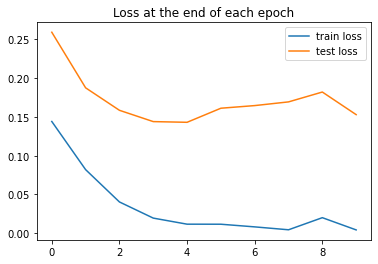

In [16]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

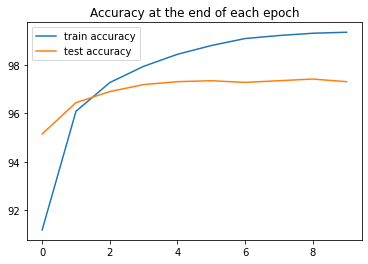

In [17]:
plt.plot([t / 600 for t in train_correct], label='train accuracy')
plt.plot([t / 100 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

**QUESTION** : how good our model is fitting the data?

## Evaluate Test Data


**EXERCISE**: Extract the data all at once (not in batches) and compute the model accuracy


In [18]:
# Extract the data all at once, not in batches
test_ds = tf.data.Dataset.from_tensor_slices((X_test_data, y_test_data)).batch(10000)
for b, (images,labels) in enumerate(test_ds): 
    break

print(images.shape)
print(labels.shape)
print((labels.numpy() == y_test_data).sum())  # to verify that dat were extracted correctly

(10000, 28, 28, 1)
(10000,)
10000


In [20]:
# Compute the accuracy
images = tf.reshape(images,shape=(10000,-1))
y_val = model(images, training=False)
predicted = tf.argmax(y_val, 1).numpy()
accuracy_test = np.equal(labels,predicted).sum() / 10000
print(accuracy_test * 100)

97.32


In [22]:
labels.numpy()

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [23]:
# print a row of values for reference
#np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted, labels.numpy()))

[[0 1 2 3 4 5 6 7 8 9]]

[[ 971    0    4    0    0    2    3    0    4    2]
 [   1 1124    4    0    0    1    3    4    0    4]
 [   1    3 1010    4    6    0    6    9    8    0]
 [   1    1    3  993    1   18    2    2   18    9]
 [   1    0    1    0  957    2    6    0    3    7]
 [   1    1    0    2    0  858   10    0    7    5]
 [   1    2    1    0    2    1  924    0    1    0]
 [   2    1    6    5    4    5    0 1009    7   15]
 [   1    3    3    1    2    3    4    2  923    4]
 [   0    0    0    5   10    2    0    2    3  963]]


**QUESTION**: in which classes the model perform the better? And in which the worst?

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [24]:
misses = np.array([])
for i in range(len(predicted)):
    if predicted[i] != labels.numpy()[i]:
        misses = np.append(misses,i).astype('int64')

**EXERCISE**:
1. Display the number of misses
2. Plot the first 10 misses, indicating both the correct labe and prediction on the plot

In [25]:
# Display the number of misses
len(misses)

268

In [26]:
# Display the first 10 index positions
misses[0:10]

array([  8,  62, 115, 217, 247, 321, 340, 391, 445, 448])

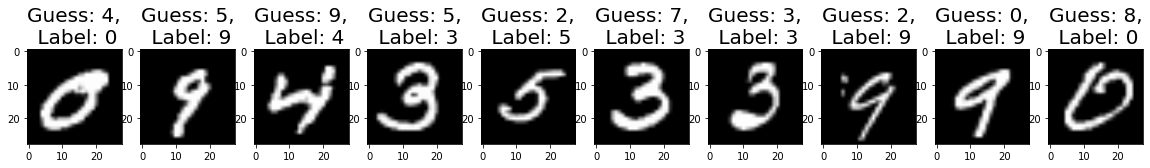

In [27]:
# Plot the first 10 misclassified digits
n_images = 10
plt.figure(figsize=(20,n_images))
for i_image, index in enumerate(misses[:n_images]):
    image, label, guess = X_test[index], y_test[index], predicted[index]
    plt.subplot(1, n_images, i_image + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray, interpolation='bilinear')
    plt.title('Guess: {},\n Label: {}'.format(guess, label), fontsize = 20)   

# EXERCISE: CONVOLUTIONAL NEURAL NETWORK
- It is left as an exercise to learn to predict digints ion the MNIST data set using a CNN
- You should use the same architecture that we use in the TD, but now the network has to be coded in Tensorflow instead of PyTorch
- You will find a guideline for the code you have to implement (this is similar to what we did during the last TD)

## Define a convolutional model

- The model has 2 convolutional layers and 2 fully connected layers
- The first convolutional layer has one input channel (the grayscale color channel). We use 6 convolutional filters of size  3x3 and we set the step size to 1.
- The second convolutional layer has 6 input channels. We use 16 convolutional filters of size 3x3 and we set the step size to 1.
- After both convolutional layers we will apply max pooling using a 2x2 window slided in step of 2.
- After the 2 convolution we will flatten the result to a vector of size 5x5x16 (the number 5 comes from the fact of applying the kernel twice, and applying pooling layers twice, so our resulting output is (((28−2)/2)−2)/2=5.5 which rounds down to 5 pixels per side.
- The we will use 2 fully connected layers with respectively 120 and 84 hidden units.

In [ ]:
class ConvolutionalNetwork(Model):


### Define loss and optimizer
We use the same loss function and optimizer as for the Multilayer Perceptron.

### Create loaders
When working with images, we want relatively small batches (use 10 elements in the batch)

## Train the model

**EXERCISE** Create a loop to train the model. 
This time we'll feed the data directly into the model without flattening it first.

**EXERCISE**
- Compare loss and accuracy between training and test data during learning
- Compute the accuracy of the model on test data
- Compute the confusion matrix
- Analyse the misses

### Loss function and accuracy

### Confusion matrix

### Misses

**QUESTIONS** 
- Is the model overfitting the data? Is it performing better than the Multilayer Perceptron?
- How does the misses look like?

## Run a new image through the model

**EXERCISE**: 
- pick a number between 0 and 9999 and generate the prediction of the model for the corresponding test data.
- plot the image with actual label and the model prediction

In [ ]:
x = 1984 # pick a number between 0 and 9999


## Visualize the convolutional filters and feature maps that the CNN is learning

You can find some guidelines about how to implement this in Pytorch here:

https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

But you should **implement it in Tensorflow!**